## Домашнее задание

Ваша задача изучить как различные преобразования влияют на модель и итоговый результат. 

1) Для удобства написать функцию, которая реализовала бы кросс-валидацию. Данная функция принимает на вход данные и другие аргументы на выше усмотрение, на выходе скор на кроссвалидации и его стандартное отклонение.

2) Сделать несколько различных моделей с различными признаками и способами обработки признаков.

    1. Например в первой модели будут использованы  непрерывные признаки   ['metro_km_walk', 'kremlin_km', 'full_sq'] с заполненными пропусками
    
    2. Во второй модели нормируйте признаки из первой модели (std=1, mean = 0). Изменился ли результат? 
    
    3. Во второй модели добавлены преобразованные различным образом категориальне признаки ['product_type' , 'sub_area' ] и т.д.
    
    4. В третьей добавлены datetime признаки 
    
    5. И так далее. Попробуйте реализовать различные гипотезы

3) Для каждой модели нужно сделать кросс-валидацию и засабмитить предсказание на тестовой выборке на кагл


4) Построить график зависимости Leader board score от score на кросс-валидации для всех 5 моделей. 

5) Написать отчет с выводами. 



P.S. Не забудьте про то, что вы можете делать модель для предсказания price_m2, а итоговый результат подсчитывается по price_doc

P.P.S.  Все преобразования, которые вы делаете нужно проделывать и с тестовой выборкой!

P.P.P.S. Можно использовать готовые функции и преобразования из sklearn.

## 0) Импорты и данные

In [16]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [1]:
# раскомментировать для google.colab

# from google.colab import files
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [230]:
# подгружаем данные

# раскомментировать для google.colab
# sample_submission = pd.read_csv("/content/drive/My Drive/1_MIPTxSkolkovo/ML/sberbank-russian-housing-market/data/sample_submission.csv")
# train = pd.read_csv("/content/drive/My Drive/1_MIPTxSkolkovo/ML/sberbank-russian-housing-market/data/train.csv")
# test = pd.read_csv("/content/drive/My Drive/1_MIPTxSkolkovo/ML/sberbank-russian-housing-market/data/test.csv")

# закомментировать для google.colab
sample_submission = pd.read_csv("../data/sample_submission.csv")
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

## 1) Функция кросс-валидации

На вход: датафрейм, столбцы-фичи, столбец-таргет, количество фолдов

На выход: скор на кроссвалидации по RMSLE, его стандартное отклонение, значения RMSLE по фолдам

In [4]:
def cross_validation(data, features, target, splits = 5):
    rmsle_list = []

    kf = KFold(n_splits = splits, shuffle = False)
    for i, (train_index, val_index) in enumerate(kf.split(data)):
        train_part = data.loc[train_index, : ]
        val_part = data.loc[val_index, : ]

        model = SGDRegressor()
        model.fit(X = train_part[features], y = train_part[target])
        val_prediction = model.predict(val_part[features]).clip(0, 10000000000000)

        metric = math.sqrt(mean_squared_log_error(val_prediction,  val_part[target]))
        rmsle_list.append(metric)
        
    return np.mean(rmsle_list), np.std(rmsle_list), rmsle_list

## 2) Модели

#### 2.0) Список

In [22]:
# список для значений кросс-валидации по 5 моделям
cv_list = [0] * 5

#### 2.1) Непрерывные признаки с заполненными пропусками

*   Таргет: price_doc
*   Признаки: 'metro_km_walk', 'kremlin_km', 'full_sq'
*   Пропуски заполнены медианой

In [33]:
# данные для модели 1

features = ['metro_km_walk', 'kremlin_km', 'full_sq']
target = 'price_doc'

train_1 = train[features + [target]]

In [34]:
# функция для заполнения пропусков медианой
def fill(frame, columns):
    for col in columns:
        frame[col].fillna(frame[col].median(), inplace = True)

In [ ]:
# заполняем пропуски медианой в train и test
fill(train_1, features + [target])
fill(test, features)

In [36]:
# кросс-валидация
cv = cross_validation(train_1, features, target)
cv_list[0] = cv[0]
cv

(9.624585487435827,
 4.039169551934684,
 [4.408793039799296,
  7.264502556352285,
  15.644655500377716,
  12.78455270756491,
  8.020423633084926])

In [37]:
# итоговая модель
model = SGDRegressor()
model.fit( X=train_1[features], y = train_1[target])
test_prediction = model.predict(test[features])
sample_submission['price_doc'] = test_prediction
sample_submission['price_doc'] = sample_submission['price_doc'].clip(1, 10000000000000) 
sample_submission.to_csv('predict1.csv', index = False)

In [38]:
# сохраняем файл с предсказанными значениями
# files.download("predict1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 2.2) Нормированные признаки из первой модели

*   Таргет: price_doc
*   Признаки: 'metro_km_walk', 'kremlin_km', 'full_sq'
*   Пропуски заполнены медианой
*   Признаки нормированы

In [133]:
# данные для модели 2
features = ['metro_km_walk', 'kremlin_km', 'full_sq']
target = 'price_doc'

train_2 = train[features + [target]]
test_2 = test

In [41]:
# функция для нормализации переменных
def normalize(frame, columns):
    for col in columns:
        frame[col].fillna(frame[col].median(), inplace = True) # заполняем NaN медианами
        frame[col] = frame[col].clip(0.0000001, 100000000000000000) # обрезаем неположительные значения
        frame[col] = stats.boxcox(frame[col])[0] # бокс-кокс

In [ ]:
# нормализуем данные в train и test
normalize(train_2, features)
normalize(test_2, features)

In [137]:
# кросс-валидация
cv = cross_validation(train_2, features, target)
cv_list[1] = cv[0]
cv

(1.3710114633550659,
 0.6524395493203788,
 [0.8672368509709482,
  0.914041293748768,
  1.0640892129338202,
  1.3851333081931612,
  2.624556650928631])

In [138]:
# итоговая модель
model = SGDRegressor()
model.fit( X=train_2[features], y = train_2[target])
test_prediction = model.predict(test[features])
sample_submission['price_doc'] = test_prediction
sample_submission['price_doc'] = sample_submission['price_doc'].clip(1, 10000000000000) 
sample_submission.to_csv('predict2.csv', index = False)

In [139]:
# сохраняем файл с предсказанными значениями
# files.download("predict2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 2.3) Целевая переменная - цена за м2

*   Таргет: price_per_m2 (цена за м2)
*   Признаки: 'metro_km_walk', 'kremlin_km'
*   Пропуски заполнены медианой
*   Признаки нормированы

In [ ]:
# данные для модели 3
features = ['metro_km_walk', 'kremlin_km']
train_3 = train[features + ['price_doc', 'full_sq']]

# нормализуем признаки
normalize(train_3, features)
# заполняем пропуски медианами
fill(train_3, ['price_doc', 'full_sq'])
train_3['price_doc'] = train_3['price_doc'].clip(1, 100000000000000000)
train_3['full_sq'] = train_3['full_sq'].clip(1, 100000000000000000)

# расчет цены за м2
train_3['price_per_m2'] = train_3['price_doc'] / train_3['full_sq']
target = 'price_per_m2'

# нормализуем признаки в тестовой выборке
test_3 = test
normalize(test_3, features)

In [113]:
# кросс-валидация
cv = cross_validation(train_3, features, target)
cv_list[2] = cv[0]
cv

(0.5748219888242985,
 0.09572237259789954,
 [0.6599253206158476,
  0.4753456915438834,
  0.7166717130948264,
  0.5257336262567975,
  0.49643359261013736])

In [114]:
# итоговая модель
model = SGDRegressor()
model.fit( X=train_3[features], y = train_3[target])
test_prediction = model.predict(test_3[features])
test_3['price_per_m2'] = test_prediction
test_3['price_doc'] = test_3['price_per_m2'] * test_3['full_sq']
sample_submission['price_doc'] = test_3['price_doc']
sample_submission['price_doc'] = sample_submission['price_doc'].clip(1, 1000000000000000) 
sample_submission.to_csv('predict3.csv', index = False)

In [116]:
# сохраняем файл с предсказанными значениями
#files.download("predict3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 2.4) Категориальные признаки, целевая - цена за м2

*   Таргет: price_per_m2 (цена за м2)
*   Признаки: 'metro_km_walk', 'kremlin_km', 'product_type', 'sub_area'
*   Пропуски заполнены медианой
*   Непрерывные признаки нормированы
*   Категориальные признаки закодированы: 'product_type' (закодированы 0 и 1), 'sub_area' (закодированы в зависимости от средней цены в районе)

In [ ]:
# данные для модели 4
features = ['metro_km_walk', 'kremlin_km']
features_cat = ['product_type', 'sub_area']

test_4 = test
train_4 = train[features + features_cat + ['price_doc', 'full_sq']]

# нормализуем числовые признаки
normalize(train_4, features)

# заполняем пропуски медианами
fill(train_4, ['price_doc', 'full_sq'])
train_4['price_doc'] = train_4['price_doc'].clip(1, 100000000000000000)
train_4['full_sq'] = train_4['full_sq'].clip(1, 100000000000000000)

# заполняем медианами
fill(test_4, ['full_sq'])

# целевая - цена за м2
train_4['price_per_m2'] = train_4['price_doc'] / train_4['full_sq']
target = 'price_per_m2'

# нормализуем признаки в тестовой выборке
normalize(test_4, features)

In [ ]:
# кодируем категориальные признаки
train_4['product_type'] = train_4['product_type'].replace( { 'Investment':1,'OwnerOccupier':0  })
sub_area_target_encoding = train_4.groupby(['sub_area'])['price_per_m2'].mean()
train_4['sub_area'] = train_4['sub_area'].map(sub_area_target_encoding)

test_4['product_type'] = test_4['product_type'].replace( { 'Investment':1,'OwnerOccupier':0  })
test_4['sub_area'] = test_4['sub_area'].map(sub_area_target_encoding)
test_4['full_sq'] = test_4['full_sq'].clip(0.00001, 100000000000000)
test_4['product_type'].fillna(1, inplace = True)

In [273]:
# кросс-валидация
cv = cross_validation(train_4, features + features_cat, target)
cv_list[3] = cv[0]
cv

(14.32874660773447,
 3.21136940424627,
 [11.591909926648428,
  18.293615237989453,
  18.228351561031843,
  11.745433478014986,
  11.784422834987641])

In [167]:
# итоговая модель
model = SGDRegressor()
model.fit( X=train_4[features], y = train_4[target])
test_prediction = model.predict(test_4[features])
test_4['price_per_m2'] = test_prediction
test_4['price_doc'] = test_4['price_per_m2'] * test_4['full_sq']
sample_submission['price_doc'] = test_4['price_doc']
sample_submission.to_csv('predict4.csv', index = False)

In [170]:
# сохраняем файл с предсказанными значениями
#files.download("predict4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 2.5) Добавлены datetime признаки

*   Таргет: price_per_m2 (цена за м2)
*   Признаки: 'metro_km_walk', 'kremlin_km', 'month', 'year'
*   Пропуски заполнены медианой
*   Непрерывные признаки нормированы

In [233]:
# datetime признаки в datetime формат
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [186]:
def get_date_time_features(timestamp_series: pd.Series) -> pd.DataFrame:
    
    output= pd.DataFrame()
    output['timestamp']= timestamp_series
    output['month'] = timestamp_series.dt.month.astype(np.int8) 
    output['day_week'] = timestamp_series.dt.dayofweek.astype(np.int8)
    output['day_month_datetime'] =timestamp_series.dt.day.astype(np.int8)
    output['year'] = timestamp_series.dt.year.astype(np.int16)
    output['seconds'] = timestamp_series.astype(int)/1_000_000_000_000 
    return output

In [234]:
train = pd.concat( [train, get_date_time_features(train['timestamp'])] , axis=1 )
test = pd.concat( [test, get_date_time_features(test['timestamp'])] , axis=1 )

In [ ]:
# данные для модели 5
features_num = ['metro_km_walk', 'kremlin_km']
features_date = ['month', 'year']

test_5 = test[features_num + features_date + ['full_sq']]
train_5 = train[features_num + features_date + ['price_doc', 'full_sq']]

# нормализуем числовые признаки
normalize(train_5, features_num)
normalize(test_5, features_num)

# заполняем пропуски медианами
fill(train_5, ['price_doc', 'full_sq'])
train_5['price_doc'] = train_5['price_doc'].clip(1, 100000000000000000)
train_5['full_sq'] = train_5['full_sq'].clip(1, 100000000000000000)

# заполняем медианами
fill(test_5, ['full_sq'])

# целевая - цена за м2
train_5['price_per_m2'] = train_5['price_doc'] / train_5['full_sq']
target = 'price_per_m2'

In [243]:
# кросс-валидация
cv = cross_validation(train_5, features, target)
cv_list[4] = cv[0]
cv

(0.5882752762871117,
 0.17227423031581687,
 [0.931510110962109,
  0.4778158789554853,
  0.5170534316349326,
  0.518862659408638,
  0.49613430047439383])

In [ ]:
# итоговая модель
model = SGDRegressor()
model.fit( X=train_5[features], y = train_5[target])
test_prediction = model.predict(test_5[features])
test_5['price_per_m2'] = test_prediction
test_5['price_doc'] = test_5['price_per_m2'] * test_5['full_sq']
sample_submission['price_doc'] = test_5['price_doc']
sample_submission.to_csv('predict5.csv', index = False)

In [245]:
# сохраняем файл с предсказанными значениями
#files.download("predict5.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3) Графики скоров моделей и выводы

#### 3.1) Графики

In [256]:
# скор на Kaggle
kaggle_private = [1.23717, 0.61194, 0.41959, 0.42025, 0.42980]
kaggle_public = [1.17708, 0.56518, 0.36422, 0.36483, 0.36971]

In [257]:
# сравнение скора на кросс-валидации со скором на Kaggle
df_score = pd.DataFrame(list(zip(cv_list, kaggle_private, kaggle_public)), columns = ['cross_validation', 'kaggle_private', 'kaggle_public'])
df_score

cross_validation  kaggle_private  kaggle_public
0          9.624585         1.23717        1.17708
1          1.371011         0.61194        0.56518
2          0.574822         0.41959        0.36422
3         16.898237         0.42025        0.36483
4          0.588275         0.42980        0.36971

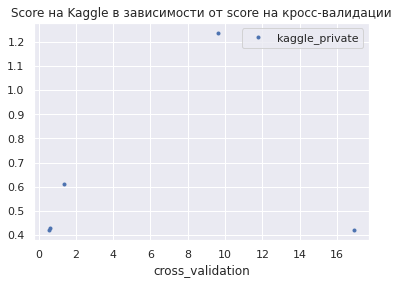

In [266]:
df_score.plot(style = '.', x='cross_validation', y='kaggle_private', title = 'Score на Kaggle в зависимости от score на кросс-валидации')
plt.show()

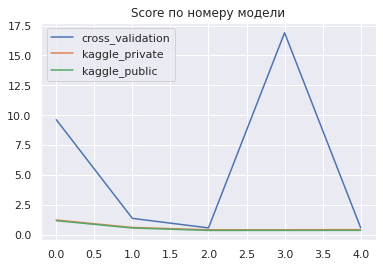

In [268]:
df_score.plot(title = 'Score по номеру модели')
plt.show()

#### 3.2) Выводы

**Модели только с непрерывными числовыми признаками (1-3):**

1. Изначальная модель (с признаками: площадь, расстояние до метро и расстояние до Кремля) показывает достаточно плохой скор и на кросс-валидации, и на лидер-борде (9.6 и 1.2 соответственно)
2. Нормирование признаков значительно улучшает качество модели (скор на Leader board 0.6 против 1.2)
3. Использование в качестве целевой переменной площади за м2 также улучшает модель (скор 0.4 против 0.6)

*Таким образом, нормирование и замена целевой переменной на более подходящую по смыслу улучшили модель.*

**Модели с категориальными и временными признаками (4-5):**

В качестве базовой модели для моделей с категориальными и временными признаками использовалась модель 3 как лучшая из ранее рассмотренных моделей.

1. Включение категориальных признаков (район и цель покупки) значительно ухудшило скор на кросс-валидации (от 11 до 18 в зависимости от фолда). На лидерборде скор относительно базовой модели тоже ухудшился, но незначительно (примерно на 0.001).
2. Включение временных признаков (год и месяц покупки) незначительно ухудшило скор и на кросс-валидации, и на лидер-борде.

*Таким образом, факторы района, цели покупки и времени сделки оказались менее важными для цены за 1 м2, чем рассмотренные ранее признаки (расстояние до метро и расстояние до центра). Возможно, стоит рассмотреть другие категориальные признаки или иначе их обработать для включения в модель. Что касается времени покупки, то, возможно, стоит подставлять данные факторы иначе, учитывая специфику того, что они отражают время, а не просто непрерывные числовые признаки.*

**Сравнение score на кросс-валидации и на Leader board:**

Значения коррелируют, хотя на кросс-валидации разброс значений больше: худшие модели показывают значительно более высокое значение по RMSLE. Также происходит нечто странное с моделью 4 (с категориальными переменными): скор на кросс-валидации очень плохой, в то время как на Kaggle скор отличается от базовой модели очень незначительно.

**Общий вывод:**

*Нормировать признаки и выбирать наиболее осмысленный таргет - полезно, а включение лишних признаков может незначительно ухудшить модель.*